# PyRV32 cheap self-verification

This 'cheap' verification runs a test program on the target and checks if it reaches a specific program counter.
If a test fails, the CPU is stuck in a break point. This is only for demonstration purposes, the full verification is done by an adaptation of the [official Risc-V test suite](https://github.com/riscv/riscv-tests).


In [1]:
import sys
sys.path.append("../../../pyrv32")
sys.path.append("..")

sys.path.insert(0, "/home/pyosys/src/myhdl/myhdl-local")

Remove previously generated VCD files:

In [2]:
!rm *.vcd

rm: cannot remove '*.vcd': No such file or directory


## Peripheral emulation

First, we configure some virtual RAM using a dictionary.

In [3]:
ram_data0 = {}
ram_data1 = {}
ram_data2 = {}
ram_data3 = {}

ram_data0[0x20] = 0xce
ram_data1[0x20] = 0xfa
ram_data2[0x20] = 0xad
ram_data3[0x20] = 0x0b

# SystemID code
p = 0x10000010
ram_data0[p] = 0xde
ram_data1[p] = 0xad
ram_data2[p] = 0xfa
ram_data3[p] = 0xce

# RAM bank proxy:
dmemory = [ram_data0, ram_data1, ram_data2, ram_data3]


Then we initialize the memory with a compiled program (see `main.c`) and print out all function symbols:

In [4]:
from loader import load_elf
from config import *


PROGNAME = "/home/pyosys/src/myhdl/myhdl-local/example/ipynb/work/pyrv32/main.elf"

rom_data = list(range(2**CONFIG_BRAM_ADDR_WIDTH))

symbols = load_elf(PROGNAME, rom_data, dmemory, debug = False)
# Reverse lookup:
function_addresses =  {addr.st_value: sym for sym, addr in symbols.items() if addr.st_info == 18} 
print("====== Function addresses =====")
for a, n in function_addresses.items():
    print("%08x:      %s " % (a, n))

Got sym section .symtab
Got str section .strtab
====== Function addresses =====
00000140:      test_iomem 
000003e0:      test_const 
000001d8:      output 
0000007c:      func_b 
00000254:      sum 
00000094:      test_alu 
000004ec:      run_test 
00000234:      fill 
0000057c:      emulation 
0000027c:      casetest 
000002c8:      test_division 
00000338:      test 
000000a0:      test_ldst 
00000310:      arith_test 
0000008c:      func_d 
0000043c:      run_haz_load_coll 
00000320:      test_funcp 
000000ec:      test_irq_handler 
000005b0:      main 
000004c0:      test_last 
000001f4:      divide 
00000318:      functest 
000003fc:      test_load_hazard 
000001c4:      test_waitflag 
0000012c:      test_subsequent_access_hazard 
00000074:      func_a 
00000430:      mem_reset 
00000484:      test_haz_load_coll 
00000084:      func_c 
00000128:      exception_handler 


## Simulation of CPU in MyHDL

This is a simple test bench for the pyrv32 CPU. It instances a **pyrv32** plus the I/O emulation setup configured above.

In [5]:
from core import pyrv32_cpu
from config import *
from riscv32_insn import *
from emulation import instruction_rom, io_emulation
from pyrv32_types import *
from tap import Tap
from ramio import DmemPort, ImemPort, IOmemPort

@block
def test_pyrv32(mem_log, START, STOP):
    clk = Signal(bool(0))

    reset = ResetSignal(0, 1, isasync = False)
    
    imem = ImemPort(CONFIG_ADDR_WIDTH)
    dmem = IOmemPort(CONFIG_ADDR_WIDTH)

    exsig = ExcSignals()

    tap = Tap(Instruction(INSN_NOP))

    pcrel_addr = Signal(intbv(0, min=0, max=2**CONFIG_BRAM_ADDR_WIDTH))
    pcrel_data = Signal(bv32(0))

    data_addr = Signal(modbv(0)[CONFIG_BRAM_ADDR_WIDTH:])
    insn_addr = Signal(modbv(0)[CONFIG_BRAM_ADDR_WIDTH:])

    rom_inst = instruction_rom(clk, imem.ire, insn_addr, imem.idata, \
        pcrel_addr, pcrel_data, rom_data)
    # Instance of a pyrv32 CPU:
    cpu_inst = pyrv32_cpu(clk, reset, tap, exsig, imem, dmem, START)

    ram_inst = io_emulation(clk, dmem, LOG_PSEUDO_MMR, mem_log, dmemory)

    @always(delay(1))
    def clkgen():
        clk.next = not clk
        
    @always_comb
    def assign():
        insn_addr.next = imem.iaddr[:2]
        pcrel_addr.next = data_addr[:PC_ADDRESS_LSB] & \
            (2**CONFIG_BRAM_ADDR_WIDTH - 1)
        
    @instance
    def stimulus():
        reset.next = 1
        yield delay(10)
        reset.next = 0
        
        msg = "Abort"
        
        for i in range(10000):
            yield(clk.posedge)
            if tap.curpc == STOP:
                msg = "Completed"
                break
        print("Stop at PC %08x" % tap.curpc)
        raise StopSimulation(msg)
    
    return instances()

Run the simulation:

In [6]:
f = open("/tmp/rv32.log", "w")

startaddr = symbols['_start'].st_value
stopaddr = symbols['terminate_emulation'].st_value

tb = test_pyrv32(f, startaddr, stopaddr)
tb.config_sim(backend = 'myhdl', timescale="1ps", trace=False)
tb.run_sim()
tb.quit_sim()

f.close()

Stop at PC 00000018


<class 'myhdl.StopSimulation'>: Completed


### Dump logged MMR accesses

The virtual console is logged into this file:

In [7]:
! cat /tmp/rv32.log

## Co-Simulation of synthesized Risc-V

In [8]:
from myhdl.conversion import yshelper as ys

def synthesize_pyrv32():
    clk = Signal(bool(0))

    reset = ResetSignal(0, 1, isasync = False)
    
    imem = ImemPort(CONFIG_ADDR_WIDTH)
    dmem = IOmemPort(CONFIG_ADDR_WIDTH)

    exsig = ExcSignals()

    tap = Tap(Instruction(INSN_NOP))

    # Instance of a pyrv32 CPU:
    cpu_inst = pyrv32_cpu(clk, reset, tap, exsig, imem, dmem, 0)
    design = ys.Design("pyrv32")
    cpu_inst.convert("yosys_module", design)
    return design



In [9]:
# design.test_synth()

In [10]:
# design.run("flatten; opt")

In [11]:
design = synthesize_pyrv32()
# txt = design.run("check")
# print(txt)

Legacy class tap
Legacy class exception
Legacy class imem
Legacy class dmem
CREATE Module: 'regno_decode_1'
Adding module with name: regno_decode_32_5_5_5
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_DECODE_1_REGNO_DECODE_1_WORKER' 
DONE instancing submodules
CREATE Module: 'instruction_decode_1'
Legacy class action
Adding module with name: instruction_decode_32_5_3_32
SIGNAL ARRAY 'imm21_upper'
SIGNAL ARRAY 'upper'
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_DECODE_1_INSTRUCTION_DECODE_1_WORKER' 
APPEND OPEN OTHER: ../../../pyrv32/riscv32i.py:95 load_mode
APPEND OPEN OTHER: ../../../pyrv32/riscv32i.py:112 load_mode
APPEND OPEN OTHER: ../../../pyrv32/riscv32i.py:207 aop
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_DECODE_1_INSTRUCTION_DECODE_1_IMM_EXTEND' 
FUNCTION : ../../../pyrv32/riscv32i.py:268 fn: UNDEFINED args: [32]
DONE instancing submodules
CREATE Module: 'alu_1'
Adding module with name: alu_1_1_4_32_32_5_32
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_ALU_1_WORKER' 
TRUNC: ../../../pyrv32/arith.py:14

Legacy class action
Legacy class evt
Legacy class haz
Legacy class reg
Legacy class mem
Legacy class tap
Adding module with name: execute_1_1_1_5_3_32_5_15_15
Legacy class tap
Legacy class csrreg
Legacy class action
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_MEPC_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_CSR_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_BYPASS' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_MUX' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_EVT_RETURN_FROM_ISR' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_MEMORY_ACCESS_HANDLE' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_INSN_EXEC' 
APPEND OPEN DEFAULT: ../../../pyrv32/pyrv32_exec.py:205 csr_xs
APPEND OPEN DEFAULT: ../../../pyrv32/pyrv32_exec.py:205 action_rete
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_1_BRANCH_COMPARE' 
APPEND OPEN DEFAULT: ../../../pyrv32/pyrv32_exec.py:237 evt_idle
APPEND OPEN DEFAULT: ../../../pyrv32/pyrv32_exec.

TIE OTHER: ../../../pyrv32/core.py:370 irqack
TIE DEFAULT: ../../../pyrv32/core.py:370 irqprio
TIE OTHER: ../../../pyrv32/core.py:370 irqlatch0
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_PIPECONTROL' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_ASSIGN_DEBUGPC' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_BUFFER' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_BRANCH_EVT' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZ_SUBSEQUENT_ACCESS' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZARD_BYPASS' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZ_ACCESS' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HANDLE_MEMORY_DELAY_LOGIC' 
APPEND OPEN OTHER: ../../../pyrv32/core.py:521 lhold
APPEND OPEN OTHER: ../../../pyrv32/core.py:524 lhold
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZ_LOAD_COLL' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZ_DELAYED_WB' 
APPEND OPEN OTHER: ../../../pyrv32/core.py:550 haz_s1bypass_delayed
APPEND OPEN OTHER: ../../../pyrv32/core.py:552 haz_s2bypass_delayed
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_COMMON' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_REG_WB

Generating RTL image...
Display...


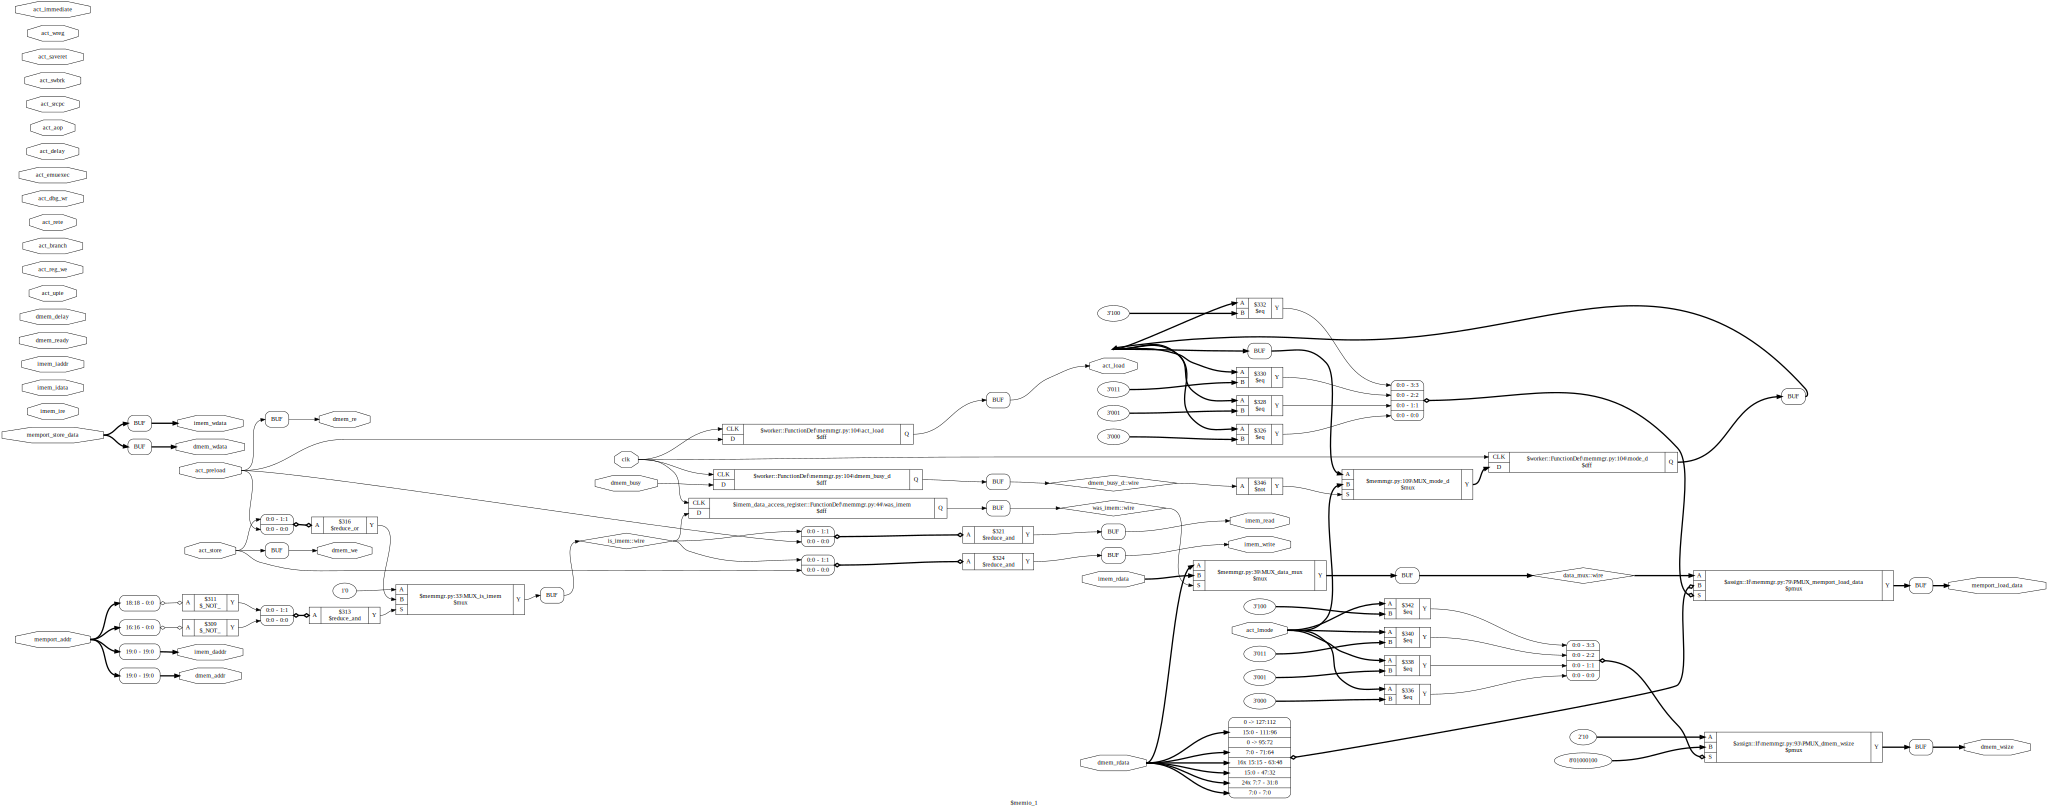

In [12]:
from ys_aux import to_svg
display(to_svg(design, "$memio_1", 400))
design.write_verilog("test_pyrv32")

In [13]:
from ecp5aux import synthesize

design = synthesize_pyrv32()
# synthesize(design)
# # json_filename = "pyrv32.json"

# # design.run("write_json %s" % json_filename)

Legacy class tap
Legacy class exception
Legacy class imem
Legacy class dmem
CREATE Module: 'regno_decode_0_0'
Adding module with name: regno_decode_32_5_5_5
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_DECODE_0_0_REGNO_DECODE_0_0_WORKER' 
DONE instancing submodules
CREATE Module: 'instruction_decode_0_0'
Legacy class action
Adding module with name: instruction_decode_32_5_3_32
SIGNAL ARRAY 'imm21_upper'
SIGNAL ARRAY 'upper'
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_DECODE_0_0_INSTRUCTION_DECODE_0_0_WORKER' 
APPEND OPEN OTHER: ../../../pyrv32/riscv32i.py:95 load_mode
APPEND OPEN OTHER: ../../../pyrv32/riscv32i.py:112 load_mode
APPEND OPEN OTHER: ../../../pyrv32/riscv32i.py:207 aop
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_DECODE_0_0_INSTRUCTION_DECODE_0_0_IMM_EXTEND' 
FUNCTION : ../../../pyrv32/riscv32i.py:268 fn: UNDEFINED args: [32]
DONE instancing submodules
CREATE Module: 'alu_0_0'
Adding module with name: alu_1_1_4_32_32_5_32
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_ALU_0_0_WORKER' 
TRUNC: ../..

Legacy class action
Legacy class evt
Legacy class haz
Legacy class reg
Legacy class mem
Legacy class tap
Adding module with name: execute_1_1_1_5_3_32_5_15_15
Legacy class tap
Legacy class csrreg
Legacy class action
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_MEPC_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_CSR_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_BYPASS' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_MUX' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_EVT_RETURN_FROM_ISR' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_MEMORY_ACCESS_HANDLE' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_INSN_EXEC' 
APPEND OPEN DEFAULT: ../../../pyrv32/pyrv32_exec.py:205 csr_xs
APPEND OPEN DEFAULT: ../../../pyrv32/pyrv32_exec.py:205 action_rete
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_EXECUTE_0_0_BRANCH_COMPARE' 
APPEND OPEN DEFAULT: ../../../pyrv32/pyrv32_exec.py:237 evt_idle
APPEND OPEN DEFAULT: ../../../p

TIE OTHER: ../../../pyrv32/core.py:370 irqack
TIE DEFAULT: ../../../pyrv32/core.py:370 irqprio
TIE OTHER: ../../../pyrv32/core.py:370 irqlatch0
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_PIPECONTROL' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_ASSIGN_DEBUGPC' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_BUFFER' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_BRANCH_EVT' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZ_SUBSEQUENT_ACCESS' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZARD_BYPASS' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZ_ACCESS' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HANDLE_MEMORY_DELAY_LOGIC' 
APPEND OPEN OTHER: ../../../pyrv32/core.py:521 lhold
APPEND OPEN OTHER: ../../../pyrv32/core.py:524 lhold
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZ_LOAD_COLL' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_HAZ_DELAYED_WB' 
APPEND OPEN OTHER: ../../../pyrv32/core.py:550 haz_s1bypass_delayed
APPEND OPEN OTHER: ../../../pyrv32/core.py:552 haz_s2bypass_delayed
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_COMMON' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPU_REG_WB

In [14]:
txt = design.run("stat")
print(txt)


-- Running command `stat' --

6. Printing statistics.

=== $pyrv32_cpu_1_1_c0 ===

   Number of wires:                426
   Number of wire bits:           1694
   Number of public wires:         140
   Number of public wire bits:    1028
   Number of memories:               0
   Number of memory bits:            0
   Number of processes:              0
   Number of cells:                220
     $_NOT_                          7
     $debug_logic_1                  1
     $decode_1_32_1_1_5_3_32         1
     $dff                           23
     $eq                            36
     $execute_1_1_1_5_3_32_5_15_15      1
     $fetch_1_1_1_20_1_15_15_c0      1
     $memio_1                        1
     $mux                           96
     $ne                             4
     $not                           18
     $pmux                           2
     $reduce_and                    18
     $reduce_or                     10
     $regbank_tri_1_1_1_1_5_32_5_32_5_32      1

=== $d

In [15]:
txt = design.run("write_ilang pyrv32.il")